# COLMAP Structure-from-Motion Demo

This notebook demonstrates how to use COLMAP to process videos or image sequences and generate 3D reconstructions with camera poses and point clouds.

## Overview
The pipeline will:
1. Extract frames from input video or use existing image sequence
2. Use COLMAP for feature extraction, matching, and reconstruction
3. Export 3D point cloud and camera trajectory
4. Visualize results with Open3D

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
import subprocess
from datetime import datetime
import open3d as o3d
import pycolmap

print("✓ Imports successful")
print(f"Available devices: {'CUDA' if pycolmap.has_cuda else 'CPU only'}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✓ Imports successful
Available devices: CPU only


## Configuration

In [ ]:
# Configuration parameters
CONFIG = {
    # Input/Output paths
    'video_dir': '/app/videos',
    'output_dir': '/app/outputs',
    'temp_dir': '/app/temp',
    
    # Video processing
    'frame_skip': 10,                   # Extract every 10th frame (reduced from 5)
    'max_frames': 50,                   # Reduce to 50 frames (was 100)
    'resize_factor': 0.5,               # Resize frames (1.0 = no resize)
    
    # COLMAP feature extraction
    'feature_type': 'sift',             # sift, superpoint, or orb
    'max_num_features': 4096,           # Reduce features (was 8192)
    'upright': False,                   # Use upright features
    
    # COLMAP matching
    'matching_type': 'sequential',      # Use sequential instead of exhaustive
    'match_max_ratio': 0.8,             # Lowe's ratio test threshold
    'match_confidence': 0.999,          # RANSAC confidence
    
    # COLMAP reconstruction
    'min_num_matches': 15,              # Minimum matches for image pair
    'init_max_error': 4.0,              # Maximum reprojection error for initialization
    'abs_pose_max_error': 12.0,         # Maximum absolute pose error
    'filter_max_reproj_error': 4.0,     # Maximum reprojection error for filtering
    
    # Camera model (will be auto-detected if not specified)
    'camera_model': 'PINHOLE',          # PINHOLE, RADIAL, OPENCV, etc.
    'camera_params': None,              # Auto-detect from EXIF if None
}

# Create output directories
for dir_path in [CONFIG['output_dir'], CONFIG['temp_dir']]:
    os.makedirs(dir_path, exist_ok=True)

print("✓ Configuration loaded")
print(f"Input directory: {CONFIG['video_dir']}")
print(f"Output directory: {CONFIG['output_dir']}")
print(f"Feature type: {CONFIG['feature_type']}")
print(f"Matching type: {CONFIG['matching_type']}")
print(f"Max features per image: {CONFIG['max_num_features']}")
print(f"Max frames to process: {CONFIG['max_frames']}")

## Video/Image Processing Functions

In [3]:
def extract_frames_from_video(video_path, output_dir, frame_skip=1, max_frames=None, resize_factor=1.0):
    """
    Extract frames from video file.
    
    Args:
        video_path: Path to input video
        output_dir: Directory to save frames
        frame_skip: Extract every Nth frame
        max_frames: Maximum number of frames to extract
        resize_factor: Factor to resize frames
    
    Returns:
        Number of frames extracted
    """
    os.makedirs(output_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Video properties:")
    print(f"  Total frames: {total_frames}")
    print(f"  FPS: {fps:.2f}")
    print(f"  Resolution: {width}x{height}")
    
    frame_count = 0
    extracted_count = 0
    
    # Calculate new dimensions if resizing
    if resize_factor != 1.0:
        new_width = int(width * resize_factor)
        new_height = int(height * resize_factor)
        print(f"  Resizing to: {new_width}x{new_height}")
    
    expected_frames = min(total_frames // frame_skip, max_frames or float('inf'))
    pbar = tqdm(total=int(expected_frames), desc="Extracting frames")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_skip == 0:
            # Resize if needed
            if resize_factor != 1.0:
                frame = cv2.resize(frame, (new_width, new_height))
            
            # Save frame with sequential naming
            frame_filename = f"{extracted_count:06d}.jpg"
            frame_path = os.path.join(output_dir, frame_filename)
            cv2.imwrite(frame_path, frame)
            
            extracted_count += 1
            pbar.update(1)
            
            if max_frames and extracted_count >= max_frames:
                break
        
        frame_count += 1
    
    cap.release()
    pbar.close()
    
    print(f"✓ Extracted {extracted_count} frames to {output_dir}")
    return extracted_count


def list_video_files(video_dir):
    """List all video files in directory."""
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm']
    video_files = []
    
    if os.path.exists(video_dir):
        for file in os.listdir(video_dir):
            if any(file.lower().endswith(ext) for ext in video_extensions):
                video_files.append(os.path.join(video_dir, file))
    
    return sorted(video_files)


def create_output_structure(base_output_dir, video_name):
    """Create organized output directory structure."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{video_name}_{timestamp}"
    
    output_structure = {
        'base': os.path.join(base_output_dir, run_name),
        'frames': os.path.join(base_output_dir, run_name, 'frames'),
        'colmap': os.path.join(base_output_dir, run_name, 'colmap'),
        'sparse': os.path.join(base_output_dir, run_name, 'colmap', 'sparse', '0'),
        'visualization': os.path.join(base_output_dir, run_name, 'visualization')
    }
    
    for path in output_structure.values():
        os.makedirs(path, exist_ok=True)
    
    return output_structure


def show_sample_frames(frames_dir, num_samples=4):
    """Display sample frames from the extracted sequence."""
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.png'))])
    
    if not frame_files:
        print("No frames found")
        return
    
    # Select evenly spaced samples
    step = max(1, len(frame_files) // num_samples)
    sample_files = frame_files[::step][:num_samples]
    
    fig, axes = plt.subplots(1, len(sample_files), figsize=(15, 4))
    if len(sample_files) == 1:
        axes = [axes]
    
    for i, frame_file in enumerate(sample_files):
        frame_path = os.path.join(frames_dir, frame_file)
        img = cv2.imread(frame_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"Frame {frame_file}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Video/image processing functions defined")

✓ Video/image processing functions defined


## COLMAP Pipeline Functions

In [ ]:
def extract_features(database_path, images_path, config):
    """
    Extract features from images using COLMAP CLI.
    
    Args:
        database_path: Path to COLMAP database
        images_path: Path to images directory
        config: Configuration dictionary
    """
    print(f"Extracting {config['feature_type']} features...")
    
    # Use COLMAP CLI for feature extraction (more stable)
    cmd = [
        "colmap", "feature_extractor",
        "--database_path", database_path,
        "--image_path", images_path,
        "--ImageReader.camera_model", config['camera_model'],
        "--SiftExtraction.max_num_features", str(config['max_num_features']),
        "--SiftExtraction.upright", "1" if config['upright'] else "0"
    ]
    
    # Set environment variables for headless operation
    env = os.environ.copy()
    env['QT_QPA_PLATFORM'] = 'offscreen'
    env['DISPLAY'] = ''
    
    result = subprocess.run(cmd, capture_output=True, text=True, env=env)
    if result.returncode != 0:
        print(f"STDERR: {result.stderr}")
        print(f"STDOUT: {result.stdout}")
        raise RuntimeError(f"Feature extraction failed with return code {result.returncode}")
    
    print("✓ Feature extraction complete")


def match_features(database_path, config):
    """
    Match features between images using COLMAP CLI.
    
    Args:
        database_path: Path to COLMAP database
        config: Configuration dictionary
    """
    print(f"Matching features using {config['matching_type']} strategy...")
    
    if config['matching_type'] == 'exhaustive':
        cmd = [
            "colmap", "exhaustive_matcher",
            "--database_path", database_path,
            "--SiftMatching.max_ratio", str(config['match_max_ratio'])
        ]
    elif config['matching_type'] == 'sequential':
        cmd = [
            "colmap", "sequential_matcher",
            "--database_path", database_path,
            "--SiftMatching.max_ratio", str(config['match_max_ratio']),
            "--SequentialMatching.overlap", "10",  # Match with 10 neighboring images
            "--SequentialMatching.quadratic_overlap", "1"  # Use quadratic overlap
        ]
    else:
        raise ValueError(f"Unknown matching type: {config['matching_type']}")
    
    # Set environment variables for headless operation
    env = os.environ.copy()
    env['QT_QPA_PLATFORM'] = 'offscreen'
    env['DISPLAY'] = ''
    
    result = subprocess.run(cmd, capture_output=True, text=True, env=env)
    if result.returncode != 0:
        print(f"STDERR: {result.stderr}")
        print(f"STDOUT: {result.stdout}")
        raise RuntimeError(f"Feature matching failed with return code {result.returncode}")
    
    print("✓ Feature matching complete")


def run_incremental_reconstruction(database_path, images_path, output_path, config):
    """
    Run COLMAP incremental reconstruction using CLI.
    
    Args:
        database_path: Path to COLMAP database
        images_path: Path to images directory  
        output_path: Path to output sparse reconstruction
        config: Configuration dictionary
    
    Returns:
        pycolmap.Reconstruction object
    """
    print("Running incremental reconstruction...")
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Use COLMAP CLI for mapper
    cmd = [
        "colmap", "mapper",
        "--database_path", database_path,
        "--image_path", images_path,
        "--output_path", output_path,
        "--Mapper.min_num_matches", str(config['min_num_matches']),
        "--Mapper.init_max_error", str(config['init_max_error']),
        "--Mapper.abs_pose_max_error", str(config['abs_pose_max_error']),
        "--Mapper.filter_max_reproj_error", str(config['filter_max_reproj_error'])
    ]
    
    # Set environment variables for headless operation
    env = os.environ.copy()
    env['QT_QPA_PLATFORM'] = 'offscreen'
    env['DISPLAY'] = ''
    
    result = subprocess.run(cmd, capture_output=True, text=True, env=env)
    if result.returncode != 0:
        print(f"STDERR: {result.stderr}")
        print(f"STDOUT: {result.stdout}")
        raise RuntimeError(f"Incremental reconstruction failed with return code {result.returncode}")
    
    # Load the reconstruction using pycolmap
    reconstruction_dirs = [d for d in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, d))]
    
    if not reconstruction_dirs:
        raise RuntimeError("No reconstruction found in output directory")
    
    # Load the first (and typically largest) reconstruction
    reconstruction_path = os.path.join(output_path, reconstruction_dirs[0])
    reconstruction = pycolmap.Reconstruction(reconstruction_path)
    
    print(f"✓ Reconstruction complete!")
    print(f"  Registered images: {len(reconstruction.images)}")
    print(f"  3D points: {len(reconstruction.points3D)}")
    
    if len(reconstruction.images) > 0:
        print(f"  Mean track length: {reconstruction.compute_mean_track_length():.2f}")
        print(f"  Mean observations per image: {reconstruction.compute_mean_observations_per_reg_image():.2f}")
    
    return reconstruction


def run_full_colmap_pipeline(images_path, output_dirs, config):
    """
    Run the complete COLMAP SfM pipeline using CLI commands.
    
    Args:
        images_path: Path to directory containing images
        output_dirs: Dictionary of output directories
        config: Configuration dictionary
    
    Returns:
        pycolmap.Reconstruction object
    """
    database_path = os.path.join(output_dirs['colmap'], 'database.db')
    
    try:
        # Get image files for validation
        image_files = sorted([f for f in os.listdir(images_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        
        print(f"Found {len(image_files)} images to process")
        
        # Remove existing database to start fresh
        if os.path.exists(database_path):
            os.remove(database_path)
            print("Removed existing database")
        
        # Step 1: Extract features (this will create the database automatically)
        extract_features(database_path, images_path, config)
        
        # Step 2: Match features
        match_features(database_path, config)
        
        # Step 3: Reconstruct
        reconstruction = run_incremental_reconstruction(
            database_path, images_path, os.path.dirname(output_dirs['sparse']), config
        )
        
        return reconstruction
        
    except Exception as e:
        print(f"❌ COLMAP pipeline failed: {e}")
        raise

print("✓ COLMAP pipeline functions defined")

## Visualization Functions

In [5]:
def plot_camera_trajectory(reconstruction, output_dir=None, title="Camera Trajectory"):
    """
    Plot camera trajectory from COLMAP reconstruction.
    
    Args:
        reconstruction: pycolmap.Reconstruction object
        output_dir: Directory to save plots (optional)
        title: Plot title
    """
    if len(reconstruction.images) == 0:
        print("No registered images to plot")
        return
    
    # Extract camera positions and orientations
    positions = []
    image_names = []
    
    for image_id in sorted(reconstruction.images.keys()):
        image = reconstruction.images[image_id]
        # Camera center in world coordinates
        center = -image.cam_from_world.rotation.matrix().T @ image.cam_from_world.translation
        positions.append(center)
        image_names.append(image.name)
    
    positions = np.array(positions)
    
    # Create trajectory plots
    fig = plt.figure(figsize=(15, 5))
    
    # 3D plot
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', alpha=0.7, linewidth=2)
    scatter = ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                         c=range(len(positions)), cmap='viridis', s=30)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('3D Camera Trajectory')
    
    # Top view (X-Y)
    ax2 = fig.add_subplot(132)
    ax2.plot(positions[:, 0], positions[:, 1], 'b-', alpha=0.7, linewidth=2)
    ax2.scatter(positions[:, 0], positions[:, 1], c=range(len(positions)), cmap='viridis', s=30)
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('Top View (X-Y)')
    ax2.axis('equal')
    ax2.grid(True, alpha=0.3)
    
    # Side view (X-Z)
    ax3 = fig.add_subplot(133)
    ax3.plot(positions[:, 0], positions[:, 2], 'b-', alpha=0.7, linewidth=2)
    ax3.scatter(positions[:, 0], positions[:, 2], c=range(len(positions)), cmap='viridis', s=30)
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Z (m)')
    ax3.set_title('Side View (X-Z)')
    ax3.axis('equal')
    ax3.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=[ax1, ax2, ax3], label='Frame Number', shrink=0.8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    
    # Save plot if output directory specified
    if output_dir:
        plot_file = os.path.join(output_dir, 'camera_trajectory.png')
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Camera trajectory plot saved to: {plot_file}")
    
    plt.show()
    
    # Print trajectory statistics
    if len(positions) > 1:
        distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
        total_distance = np.sum(distances)
        bbox_size = np.max(positions, axis=0) - np.min(positions, axis=0)
        
        print(f"\nTrajectory Statistics:")
        print(f"  Number of camera poses: {len(positions)}")
        print(f"  Total path length: {total_distance:.3f} m")
        print(f"  Average step size: {np.mean(distances):.3f} m")
        print(f"  Bounding box size: [{bbox_size[0]:.3f}, {bbox_size[1]:.3f}, {bbox_size[2]:.3f}] m")


def plot_reconstruction_statistics(reconstruction, output_dir=None):
    """
    Plot various reconstruction statistics.
    
    Args:
        reconstruction: pycolmap.Reconstruction object
        output_dir: Directory to save plots (optional)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Point observation counts
    if len(reconstruction.points3D) > 0:
        obs_counts = [len(point.track.elements) for point in reconstruction.points3D.values()]
        axes[0,0].hist(obs_counts, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_xlabel('Number of Observations')
        axes[0,0].set_ylabel('Number of 3D Points')
        axes[0,0].set_title(f'Point Observation Distribution\n(Total: {len(obs_counts)} points)')
        axes[0,0].grid(True, alpha=0.3)
        
        # Add statistics text
        mean_obs = np.mean(obs_counts)
        median_obs = np.median(obs_counts)
        axes[0,0].axvline(mean_obs, color='red', linestyle='--', label=f'Mean: {mean_obs:.1f}')
        axes[0,0].axvline(median_obs, color='orange', linestyle='--', label=f'Median: {median_obs:.1f}')
        axes[0,0].legend()
    
    # 2. Reprojection errors
    if len(reconstruction.points3D) > 0:
        errors = []
        for point in reconstruction.points3D.values():
            for track_element in point.track.elements:
                image = reconstruction.images[track_element.image_id]
                camera = reconstruction.cameras[image.camera_id]
                
                # Project 3D point to image
                projected = camera.world_to_image(image.cam_from_world * point.xyz)
                error = np.linalg.norm(projected - track_element.point2D)
                errors.append(error)
        
        if errors:
            axes[0,1].hist(errors, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
            axes[0,1].set_xlabel('Reprojection Error (pixels)')
            axes[0,1].set_ylabel('Number of Observations')
            axes[0,1].set_title(f'Reprojection Error Distribution\n(Mean: {np.mean(errors):.2f} px)')
            axes[0,1].grid(True, alpha=0.3)
            axes[0,1].axvline(np.mean(errors), color='red', linestyle='--', label=f'Mean: {np.mean(errors):.2f}')
            axes[0,1].legend()
    
    # 3. Image registration order
    if len(reconstruction.images) > 0:
        image_ids = sorted(reconstruction.images.keys())
        reg_order = list(range(len(image_ids)))
        axes[1,0].plot(reg_order, image_ids, 'o-', color='green', markersize=4)
        axes[1,0].set_xlabel('Registration Order')
        axes[1,0].set_ylabel('Image ID')
        axes[1,0].set_title(f'Image Registration Sequence\n({len(image_ids)} registered images)')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. 3D point cloud extent (top view)
    if len(reconstruction.points3D) > 0:
        points = np.array([point.xyz for point in reconstruction.points3D.values()])
        
        # Subsample for plotting if too many points
        if len(points) > 10000:
            indices = np.random.choice(len(points), 10000, replace=False)
            points_plot = points[indices]
        else:
            points_plot = points
        
        scatter = axes[1,1].scatter(points_plot[:, 0], points_plot[:, 1], 
                                  c=points_plot[:, 2], cmap='viridis', alpha=0.6, s=1)
        axes[1,1].set_xlabel('X (m)')
        axes[1,1].set_ylabel('Y (m)')
        axes[1,1].set_title(f'3D Points (Top View)\n{len(points)} total points')
        axes[1,1].axis('equal')
        axes[1,1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,1], label='Z (m)', shrink=0.8)
        
        # Add bounding box info
        bbox_min = np.min(points, axis=0)
        bbox_max = np.max(points, axis=0)
        bbox_size = bbox_max - bbox_min
        print(f"\n3D Point Cloud Statistics:")
        print(f"  Number of 3D points: {len(points)}")
        print(f"  Bounding box: [{bbox_size[0]:.3f}, {bbox_size[1]:.3f}, {bbox_size[2]:.3f}] m")
        print(f"  Point density: {len(points) / np.prod(bbox_size):.1f} points/m³")
    
    plt.tight_layout()
    
    # Save plot if output directory specified
    if output_dir:
        plot_file = os.path.join(output_dir, 'reconstruction_statistics.png')
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Reconstruction statistics plot saved to: {plot_file}")
    
    plt.show()


def visualize_3d_reconstruction(reconstruction, output_dir=None, point_size=1, max_points=50000):
    """
    Visualize 3D reconstruction using Open3D.
    
    Args:
        reconstruction: pycolmap.Reconstruction object
        output_dir: Directory to save screenshots (optional)
        point_size: Size of 3D points in visualization
        max_points: Maximum number of points to display
    """
    print("Creating 3D visualization...")
    
    # Create Open3D geometries
    geometries = []
    
    # Add 3D points
    if len(reconstruction.points3D) > 0:
        points = []
        colors = []
        
        point_list = list(reconstruction.points3D.values())
        if len(point_list) > max_points:
            # Subsample points
            indices = np.random.choice(len(point_list), max_points, replace=False)
            point_list = [point_list[i] for i in indices]
            print(f"Subsampled {max_points} from {len(reconstruction.points3D)} points")
        
        for point in point_list:
            points.append(point.xyz)
            colors.append(point.color / 255.0)  # Normalize to [0,1]
        
        # Create point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.array(points))
        pcd.colors = o3d.utility.Vector3dVector(np.array(colors))
        geometries.append(pcd)
    
    # Add camera poses
    if len(reconstruction.images) > 0:
        camera_size = 0.1  # Size of camera visualization
        
        for image_id, image in reconstruction.images.items():
            # Camera center
            center = -image.cam_from_world.rotation.matrix().T @ image.cam_from_world.translation
            
            # Camera orientation (simplified frustum)
            rotation = image.cam_from_world.rotation.matrix().T
            
            # Create camera coordinate frame
            camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
                size=camera_size, origin=center
            )
            camera_frame.rotate(rotation, center=center)
            geometries.append(camera_frame)
    
    # Visualize
    if geometries:
        print(f"Displaying {len(geometries)} geometry objects...")
        print("Controls:")
        print("  - Mouse: Rotate view")
        print("  - Scroll: Zoom")
        print("  - Ctrl+Mouse: Pan")
        print("  - Q or ESC: Exit")
        
        vis = o3d.visualization.Visualizer()
        vis.create_window(window_name="COLMAP 3D Reconstruction", width=1200, height=800)
        
        for geom in geometries:
            vis.add_geometry(geom)
        
        # Set point size
        render_option = vis.get_render_option()
        render_option.point_size = point_size
        
        # Run visualization
        vis.run()
        
        # Save screenshot if output directory specified
        if output_dir:
            screenshot_path = os.path.join(output_dir, 'reconstruction_3d.png')
            vis.capture_screen_image(screenshot_path)
            print(f"✓ 3D visualization screenshot saved to: {screenshot_path}")
        
        vis.destroy_window()
    else:
        print("No geometries to visualize")

print("✓ Visualization functions defined")

✓ Visualization functions defined


## Main Processing Pipeline

Let's find and process a video through the complete COLMAP Structure-from-Motion pipeline.

In [6]:
# List available video files
video_files = list_video_files(CONFIG['video_dir'])

print(f"Found {len(video_files)} video files in {CONFIG['video_dir']}:")
for i, video_file in enumerate(video_files):
    if os.path.exists(video_file):
        file_size = os.path.getsize(video_file) / (1024*1024)  # MB
        print(f"  {i}: {os.path.basename(video_file)} ({file_size:.1f} MB)")

if len(video_files) == 0:
    print(f"\\n⚠ No video files found!")
    print(f"Please place video files in: {CONFIG['video_dir']}")
    print("Supported formats: .mp4, .avi, .mov, .mkv, .wmv, .flv, .webm")
else:
    print(f"\\n📁 Available videos - run the next cell to process the first video")
    
    # Auto-select first video
    selected_video = video_files[0]
    video_name = os.path.splitext(os.path.basename(selected_video))[0]
    
    # Create output structure
    outputs = create_output_structure(CONFIG['output_dir'], video_name)
    
    print(f"\\n✅ Selected: {os.path.basename(selected_video)}")
    print(f"📝 Output will be saved to: {outputs['base']}")
    print(f"📁 Ready to start processing!")

Found 1 video files in /app/videos:
  0: drone1.mp4 (118.0 MB)
\n📁 Available videos - run the next cell to process the first video
\n✅ Selected: drone1.mp4
📝 Output will be saved to: /app/outputs/drone1_20250918_162441
📁 Ready to start processing!


### Step 1: Extract Frames from Video

🎬 Extracting frames from: drone1.mp4
Video properties:
  Total frames: 950
  FPS: 24.00
  Resolution: 3840x2160
  Resizing to: 1920x1080


Extracting frames: 100% 100/100 [00:09<00:00, 10.12it/s]


✓ Extracted 100 frames to /app/outputs/drone1_20250918_162441/frames
\n✅ Frame extraction complete!
📁 100 frames saved to: /app/outputs/drone1_20250918_162441/frames
\n📸 Sample frames:


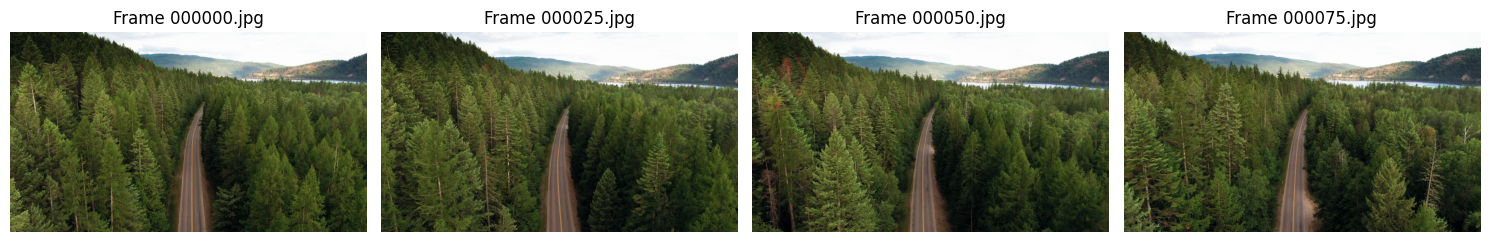

In [7]:
if 'selected_video' in locals() and os.path.exists(selected_video):
    print(f"🎬 Extracting frames from: {os.path.basename(selected_video)}")
    
    # Extract frames with configured parameters
    num_frames = extract_frames_from_video(
        video_path=selected_video,
        output_dir=outputs['frames'],
        frame_skip=CONFIG['frame_skip'],
        max_frames=CONFIG['max_frames'],
        resize_factor=CONFIG['resize_factor']
    )
    
    print(f"\\n✅ Frame extraction complete!")
    print(f"📁 {num_frames} frames saved to: {outputs['frames']}")
    
    # Show sample frames
    print(f"\\n📸 Sample frames:")
    show_sample_frames(outputs['frames'], num_samples=4)
    
else:
    print("❌ No video selected or video file not found. Please run the previous cell first.")

### Step 2: Run COLMAP Structure-from-Motion

In [ ]:
if 'num_frames' in locals() and num_frames > 0:
    print(f"🚀 Starting COLMAP Structure-from-Motion reconstruction...")
    print(f"📊 Processing {num_frames} frames from: {outputs['frames']}")
    print(f"⚙️ Using {CONFIG['feature_type']} features with {CONFIG['matching_type']} matching")
    
    try:
        # Run the complete COLMAP pipeline
        reconstruction = run_full_colmap_pipeline(
            images_path=outputs['frames'],
            output_dirs=outputs,
            config=CONFIG
        )
        
        print(f"\\n🎉 COLMAP reconstruction completed successfully!")
        
        # Print detailed reconstruction summary
        print(f"\\n📋 RECONSTRUCTION SUMMARY:")
        print(f"=" * 50)
        print(f"Input frames: {num_frames}")
        print(f"Registered images: {len(reconstruction.images)}")
        print(f"3D points: {len(reconstruction.points3D)}")
        print(f"Cameras: {len(reconstruction.cameras)}")
        print(f"Mean track length: {reconstruction.compute_mean_track_length():.2f}")
        print(f"Mean observations per image: {reconstruction.compute_mean_observations_per_reg_image():.2f}")
        
        # Save summary to file
        summary_file = os.path.join(outputs['base'], 'reconstruction_summary.txt')
        with open(summary_file, 'w') as f:
            f.write(f"COLMAP Structure-from-Motion Reconstruction Summary\\n")
            f.write(f"=" * 60 + "\\n\\n")
            f.write(f"Input video: {os.path.basename(selected_video)}\\n")
            f.write(f"Processing date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n\\n")
            f.write(f"Configuration:\\n")
            for key, value in CONFIG.items():
                f.write(f"  {key}: {value}\\n")
            f.write(f"\\nResults:\\n")
            f.write(f"  Input frames: {num_frames}\\n")
            f.write(f"  Registered images: {len(reconstruction.images)}\\n")
            f.write(f"  3D points: {len(reconstruction.points3D)}\\n")
            f.write(f"  Cameras: {len(reconstruction.cameras)}\\n")
            f.write(f"  Mean track length: {reconstruction.compute_mean_track_length():.2f}\\n")
            f.write(f"  Mean observations per image: {reconstruction.compute_mean_observations_per_reg_image():.2f}\\n")
        
        print(f"📄 Summary saved to: {summary_file}")
        
        # Export point cloud to PLY format
        ply_file = os.path.join(outputs['base'], 'point_cloud.ply')
        reconstruction.export_PLY(ply_file)
        print(f"☁️ Point cloud exported to: {ply_file}")
        
        print(f"\\n📁 All reconstruction files saved to: {outputs['base']}")
        
    except Exception as e:
        print(f"❌ COLMAP reconstruction failed: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ No frames extracted yet. Please run the frame extraction step first.")

🚀 Starting COLMAP Structure-from-Motion reconstruction...
📊 Processing 100 frames from: /app/outputs/drone1_20250918_162441/frames
⚙️ Using sift features with exhaustive matching
Found 100 images to process
Extracting sift features...


W20250918 16:24:52.204109    31 feature_extraction.cc:403] Your current options use the maximum number of threads on the machine to extract features. Extracting SIFT features on the CPU can consume a lot of RAM per thread for large images. Consider reducing the maximum image size and/or the first octave or manually limit the number of extraction threads. Ignore this warning, if your machine has sufficient memory for the current settings.
I20250918 16:24:52.204523   126 misc.cc:198] 
Feature extraction
I20250918 16:24:59.571419   151 feature_extraction.cc:254] Processed file [1/100]
I20250918 16:24:59.626420   151 feature_extraction.cc:257]   Name:            000001.jpg
I20250918 16:24:59.626472   151 feature_extraction.cc:283]   Dimensions:      1920 x 1080
I20250918 16:24:59.626479   151 feature_extraction.cc:286]   Camera:          #2 - SIMPLE_RADIAL
I20250918 16:24:59.627537   151 feature_extraction.cc:289]   Focal Length:    2304.00px
I20250918 16:24:59.629621   151 feature_extract

✓ Feature extraction complete
Matching features using exhaustive strategy...


I20250918 16:25:56.127693   159 misc.cc:198] 
Exhaustive feature matching
I20250918 16:25:56.146214   159 feature_matching.cc:231] Matching block [1/2, 1/2]
*** Aborted at 1758212756 (unix time) try "date -d @1758212756" if you are using GNU date ***


## Results Visualization

Generate comprehensive visualizations of the reconstruction results.

### Camera Trajectory Visualization

In [ ]:
if 'reconstruction' in locals():
    print("📊 Generating camera trajectory visualization...")
    
    # Plot camera trajectory in multiple views
    plot_camera_trajectory(
        reconstruction, 
        output_dir=outputs['visualization'],
        title=f"Camera Trajectory - {video_name}"
    )
    
else:
    print("❌ No reconstruction available. Please run the COLMAP reconstruction step first.")

### Reconstruction Statistics

In [ ]:
if 'reconstruction' in locals():
    print("📈 Generating reconstruction statistics...")
    
    # Plot detailed reconstruction statistics
    plot_reconstruction_statistics(
        reconstruction,
        output_dir=outputs['visualization']
    )
    
else:
    print("❌ No reconstruction available. Please run the COLMAP reconstruction step first.")

### 3D Interactive Visualization

In [ ]:
if 'reconstruction' in locals():
    print("🎮 Launching 3D interactive visualization...")
    print("Note: This will open a new window. Close it to continue.")
    
    # Launch 3D visualization with Open3D
    try:
        visualize_3d_reconstruction(
            reconstruction,
            output_dir=outputs['visualization'],
            point_size=2,
            max_points=50000
        )
    except Exception as e:
        print(f"⚠️ 3D visualization failed (this is normal in some environments): {e}")
        print("The reconstruction is still valid - check the saved point cloud file instead.")
    
else:
    print("❌ No reconstruction available. Please run the COLMAP reconstruction step first.")

## Final Summary

Review the complete reconstruction pipeline results and output files.

In [ ]:
if 'reconstruction' in locals() and 'outputs' in locals():
    print("📋 FINAL RECONSTRUCTION SUMMARY")
    print("=" * 60)
    
    print(f"\\n🎬 Input:")
    print(f"  Video: {os.path.basename(selected_video)}")
    print(f"  Extracted frames: {num_frames}")
    print(f"  Frame skip: every {CONFIG['frame_skip']} frames")
    print(f"  Resize factor: {CONFIG['resize_factor']}")
    
    print(f"\\n⚙️ COLMAP Configuration:")
    print(f"  Feature type: {CONFIG['feature_type']}")
    print(f"  Max features per image: {CONFIG['max_num_features']}")
    print(f"  Matching strategy: {CONFIG['matching_type']}")
    print(f"  Camera model: {CONFIG['camera_model']}")
    
    print(f"\\n📊 Reconstruction Results:")
    print(f"  Registered images: {len(reconstruction.images)} / {num_frames} ({100*len(reconstruction.images)/num_frames:.1f}%)")
    print(f"  3D points: {len(reconstruction.points3D):,}")
    print(f"  Cameras: {len(reconstruction.cameras)}")
    print(f"  Mean track length: {reconstruction.compute_mean_track_length():.2f}")
    print(f"  Mean observations per image: {reconstruction.compute_mean_observations_per_reg_image():.2f}")
    
    print(f"\\n📁 Generated Files:")
    
    # List all generated files with sizes
    file_list = [
        (outputs['base'], 'reconstruction_summary.txt', 'Detailed text summary'),
        (outputs['base'], 'point_cloud.ply', '3D point cloud (PLY format)'),
        (outputs['sparse'], 'cameras.bin', 'COLMAP camera parameters'),
        (outputs['sparse'], 'images.bin', 'COLMAP image poses'),
        (outputs['sparse'], 'points3D.bin', 'COLMAP 3D points'),
        (outputs['colmap'], 'database.db', 'COLMAP SQLite database'),
        (outputs['visualization'], 'camera_trajectory.png', 'Camera trajectory plot'),
        (outputs['visualization'], 'reconstruction_statistics.png', 'Statistics plots'),
        (outputs['visualization'], 'reconstruction_3d.png', '3D view screenshot (if generated)'),
    ]
    
    for base_dir, filename, description in file_list:
        filepath = os.path.join(base_dir, filename)
        if os.path.exists(filepath):
            size = os.path.getsize(filepath)
            if size > 1024*1024:
                size_str = f"{size/(1024*1024):.1f} MB"
            elif size > 1024:
                size_str = f"{size/1024:.1f} KB"
            else:
                size_str = f"{size} B"
            print(f"  ✓ {filename} ({size_str}) - {description}")
        else:
            print(f"  ✗ {filename} - {description} (not generated)")
    
    print(f"\\n🎯 Output Directory: {outputs['base']}")
    print(f"📁 Host Path: ./outputs/{os.path.basename(outputs['base'])}")
    
    print(f"\\n✅ COLMAP Structure-from-Motion pipeline completed successfully!")
    print(f"\\n💡 Next Steps:")
    print(f"  • Load the .ply file in any 3D viewer (MeshLab, CloudCompare, etc.)")
    print(f"  • Use the COLMAP binary files for further processing")
    print(f"  • Examine the visualization plots for reconstruction quality")
    
else:
    print("❌ No complete reconstruction available.")
    print("Please run through all the pipeline steps:")
    print("  1. Video selection and frame extraction")
    print("  2. COLMAP Structure-from-Motion reconstruction")
    print("  3. Visualization generation")